# Compute the power spectrum of topography for estimating the drag coefficient
Note that we need the power spectrum of ALL topography that contributes to wave generation, not just unresolved abyssal hills. In the 1-layer model, there's no internal wave generation. So we will need the topographic spectrum to include the smallest wavenumber (i.e., largest topography) that generates internal waves. 

In [1]:
%matplotlib inline

import xrft
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from gsw import f
  
import warnings
warnings.filterwarnings('ignore')

## Estimate the horizontal wavelength of mode-1 internal wave to determine the radius of the circle (filter)
The mode-n internal wave dispersion relation is $\omega_n^2 = f^2 + \frac{N^2H^2}{n^2\pi^2}k_h^2$.

For mode-1 $M_2$, the dispersion relation then becomes $\omega_{M_{2}}^2 = f^2 + \frac{N^2H^2}{\pi^2}k_h^2$

The horizontal wavenumber can be obtained following $k_h^2 = \frac{(\omega^2-f^2)\pi^2}{N^2H^2} $

In [2]:
omega_M2 = 2 * np.pi / (12*3600)
print('M2 frequency: %.5f rad/s' % omega_M2)

M2 frequency: 0.00015 rad/s


In [3]:
f_mid = f(45) 
print('f at 45deg N: %.5f rad/s' % f_mid)

f at 45deg N: 0.00010 rad/s


In [4]:
N = 2 * np.pi * 1e-3
print('Assume N = %.5f rad/s' % N)

Assume N = 0.00628 rad/s


In [5]:
H = 5000
print('Assume H = %d m' % H)

Assume H = 5000 m


In [6]:
kh = np.sqrt((omega_M2**2-f_mid**2)*np.pi**2/N**2/H**2)
print('The horizontal wavelength of the mode-1 M2 internal tides is approx. %d km.' % (2 * np.pi / kh / 1000))

The horizontal wavelength of the mode-1 M2 internal tides is approx. 612 km.


Let's select a grid point (30$^{\circ}$W, 50$^{\circ}$N) and plot the topography in a circle with a 300km radius around it.

High-res SYNBATH topog dataset: /g/data/nm03/lxy581/synbath/SYNBATH_V1.2.nc  (Downloaded from https://zenodo.org/records/5784502)

In [7]:
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')
xind = 240*150-1; yind = 240*140
print('Lon: %.1f W;' % np.abs(topog.lon[xind].values),'\nLat: %.1f N.' % topog.lat[yind].values)

Lon: 30.0 W; 
Lat: 50.0 N.


## Plot out the ocean depth in the selected region

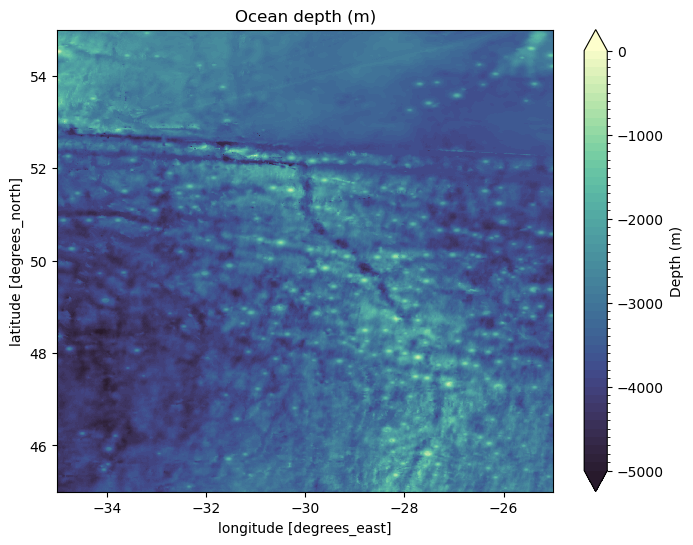

In [8]:
topog_sample = topog.z[240*135:240*145,240*145:240*155]
fig = plt.figure(figsize = (8, 6))
levels = np.arange(-5000,0+1000,1000)
xr.plot.pcolormesh(topog_sample, vmin=-5000, vmax=0, levels=51, extend='both', cmap=cm.cm.deep_r, cbar_kwargs={'label': "Depth (m)", 'ticks': levels})
plt.title('Ocean depth (m)');

## Construct a 2D isotropic filter to sample a circle around the selected grid point

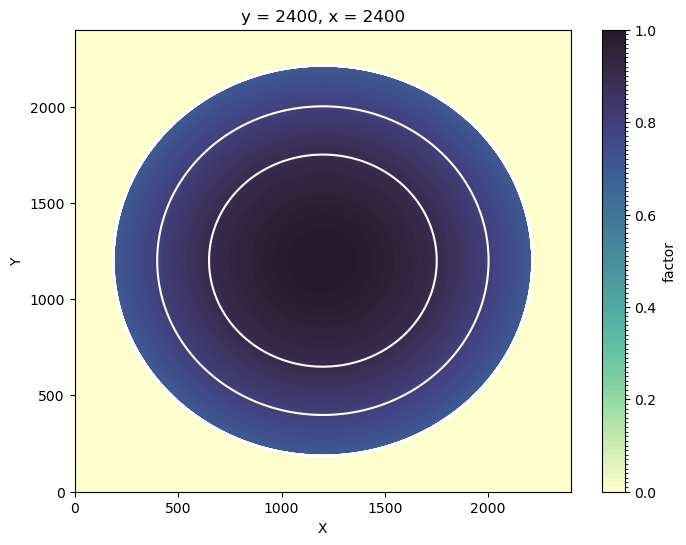

In [9]:
from scipy import signal
win_1d = signal.windows.gaussian(topog_sample.shape[0], std=topog_sample.shape[0]/2, sym=False)
win_nx = win_1d.size
win_2d = np.full((win_nx,win_nx), np.full)
win_2d = win_1d[None,:] * win_1d[:,None]
win_2d[win_2d<0.7]=0.0
win_2d_xr = xr.DataArray(win_2d, 
coords={'y': win_nx, 'x': win_nx}, 
dims=["Y", "X"])
fig = plt.figure(figsize = (8, 6))
fac_levels = np.arange(0,1+0.2,0.2)
xr.plot.pcolormesh(win_2d_xr, vmin=0, vmax=1, levels=101, extend='neither', cmap=cm.cm.deep, cbar_kwargs={'label': "factor", 'ticks': fac_levels})
xr.plot.contour(win_2d_xr,levels=np.arange(0,1,0.1),colors='w')

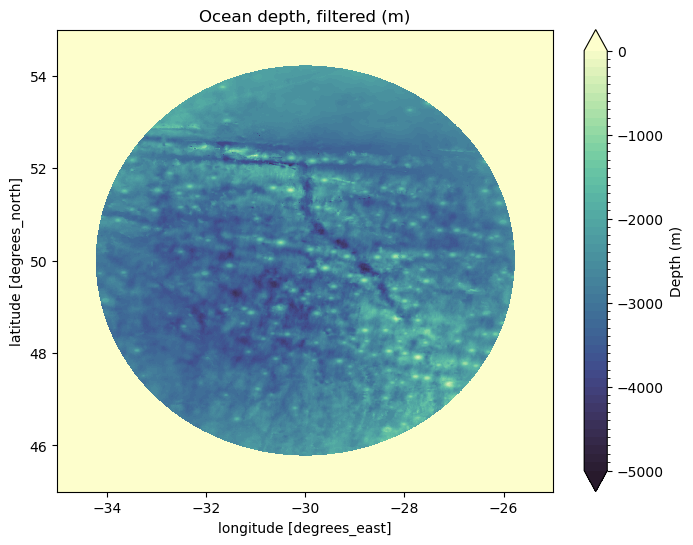

In [10]:
topog_filt = np.array(topog_sample) * np.array(win_2d_xr)
topog_filt = xr.DataArray(topog_filt, coords=topog_sample.coords, dims=topog_sample.dims)
fig = plt.figure(figsize = (8, 6))
levels = np.arange(-5000,0+1000,1000)
xr.plot.pcolormesh(topog_filt, vmin=-5000, vmax=0, levels=51, extend='both', cmap=cm.cm.deep_r, cbar_kwargs={'label': "Depth (m)", 'ticks': levels})
plt.title('Ocean depth, filtered (m)');

## Perform the spectral analysis

In [11]:
topog_spec = xrft.power_spectrum(topog_sample, window='hamming', window_correction=True, detrend='linear')

## Plot the power spectrum

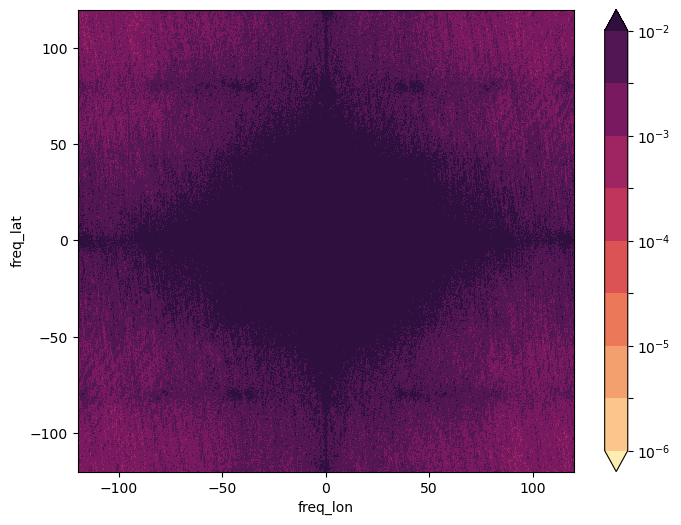

In [12]:
fig = plt.figure(figsize = (8, 6))
xr.plot.contourf(topog_spec, levels=np.logspace(-6,-2,9), extend='both', cmap=cm.cm.matter, norm=colors.LogNorm(vmin=1e-6,vmax=1e-2))
#xr.plot.contourf(topog_spec_fold, levels=np.logspace(-6,-2,9), extend='both', cmap=cm.cm.matter, norm=colors.LogNorm(vmin=1e-6,vmax=1e-2))

### Estimate kx and ky

In [13]:
# ny, nx = topog_sample.shape
# kx = np.zeros(nx) 
# for i in range(nx):
#     kx[i] = i
#     if kx[i] > nx / 2:
#         kx[i] = nx - i
# ky = np.zeros(ny) 
# for j in range(ny):
#     ky[j] = j
#     if ky[j] > ny / 2:
#         ky[j] = ny - j
# #print(np.max(kx))
# #print(kx[1200])
# topog_spec_fold = np.zeros((round(np.max(ky))+1,round(np.max(kx))+1))
# for j in range(ny):
#     for i in range(nx):
#         jj = round(ky[j])
#         ii = round(kx[i])
#         topog_spec_fold[jj,ii]=topog_spec_fold[jj,ii]+topog_spec[j,i]

## Compute the drag coefficient at this location